# Clustering Models

In [323]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import dtale
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D


In [696]:
# file = open('dataframe.p', 'rb')
# df = pickle.load(file)
# file.close()
file = open('data.p', 'rb')
df = pickle.load(file)
file.close()

In [697]:
# df = pd.concat([df2, df1['date']], axis=1)

In [698]:
df['source'].value_counts()

SCMP               542
Reuters            434
CCTV               182
ABC (Australia)    102
CNN                 81
Name: source, dtype: int64

In [699]:
# Convert source category to int: 0 - SCMP, 1 - ABC (Australia), 2 - Reuters, 3 - CCTV, 4 - CNN
cond = [df['source'] == 'SCMP',
        df['source'] == 'ABC (Australia)',
        df['source'] == 'Reuters',
        df['source'] == 'CCTV',
        df['source'] == 'CNN']
choice = [0, 1, 2, 3, 4]
df['source'] = np.select(cond, choice)

In [700]:
# df = df.loc[(df['source'] == 1)|(df['source'] == 3)|(df['source'] == 4)]

In [701]:
# df['source'] = df['source'].astype('category')

In [705]:
X = df.drop(columns=['source'])
y = df['source']

In [706]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [707]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)

In [708]:
pca_1 = PCA(n_components=6)
pca_2 = PCA(n_components=7)
pca_3 = PCA(n_components=8)

principalComponents = pca_1.fit_transform(X_train)
principalComponents = pca_2.fit_transform(X_train)
principalComponents = pca_3.fit_transform(X_train)

print(np.sum(pca_1.explained_variance_ratio_))
print(np.sum(pca_2.explained_variance_ratio_))
print(np.sum(pca_3.explained_variance_ratio_))


0.9582674442714592
0.9691076330798849
0.9778928355962556


In [709]:
pca = PCA(n_components=6)
comp = pca.fit_transform(X_train)

In [713]:
X_array = np.concatenate((comp, np.array(y_train).reshape(1072, 1)), axis=1)

In [716]:
comp_df = pd.DataFrame(data=X_array, columns=['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'source'])

In [717]:
comp_df['source'] = comp_df['source'].astype('category')

In [718]:
X1 = comp_df.drop(columns=['source'])
y1 = comp_df['source']

In [677]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [678]:
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [679]:
# pca = PCA(n_components=3)
# comp_train = pca.fit_transform(X_train)
# comp_test = pca.transform(X_test)

In [680]:
# X = df.iloc[:, 1:5].values
# y = df['source']

In [681]:
# comp_train_df = pd.DataFrame(data = comp_train, columns = ['pc1', 'pc2', 'pc3'])
# comp_test_df = pd.DataFrame(data = comp_test, columns = ['pc1', 'pc2', 'pc3'])

In [682]:
# X1 = comp_train_df.values

/Users/waynelam/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



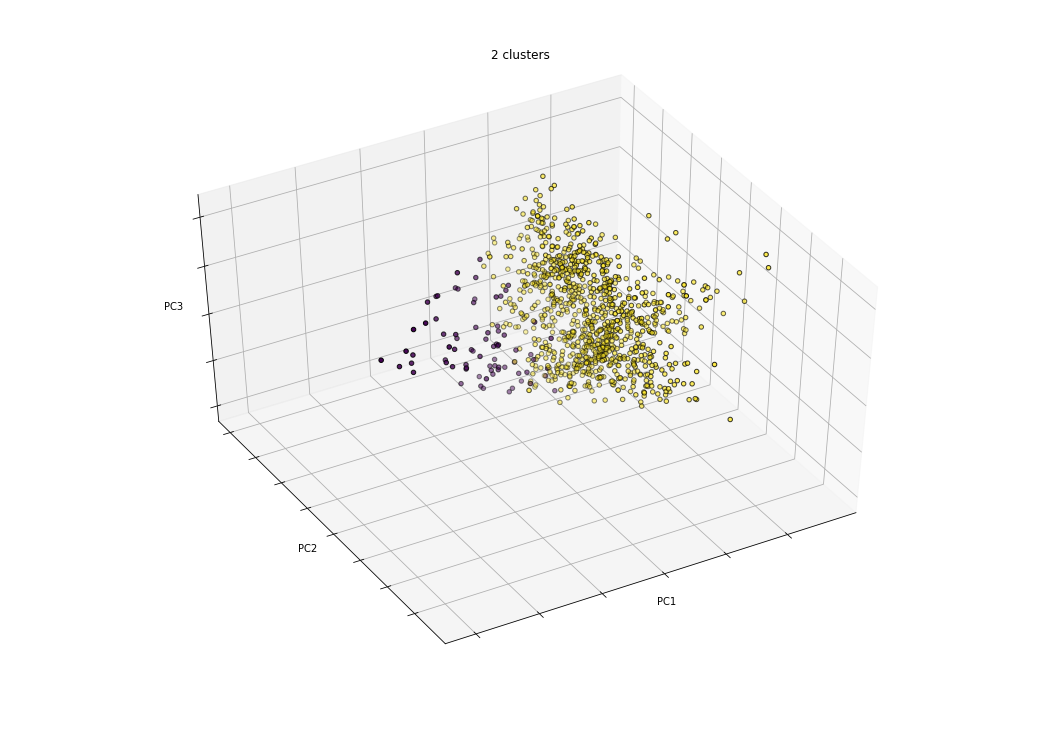

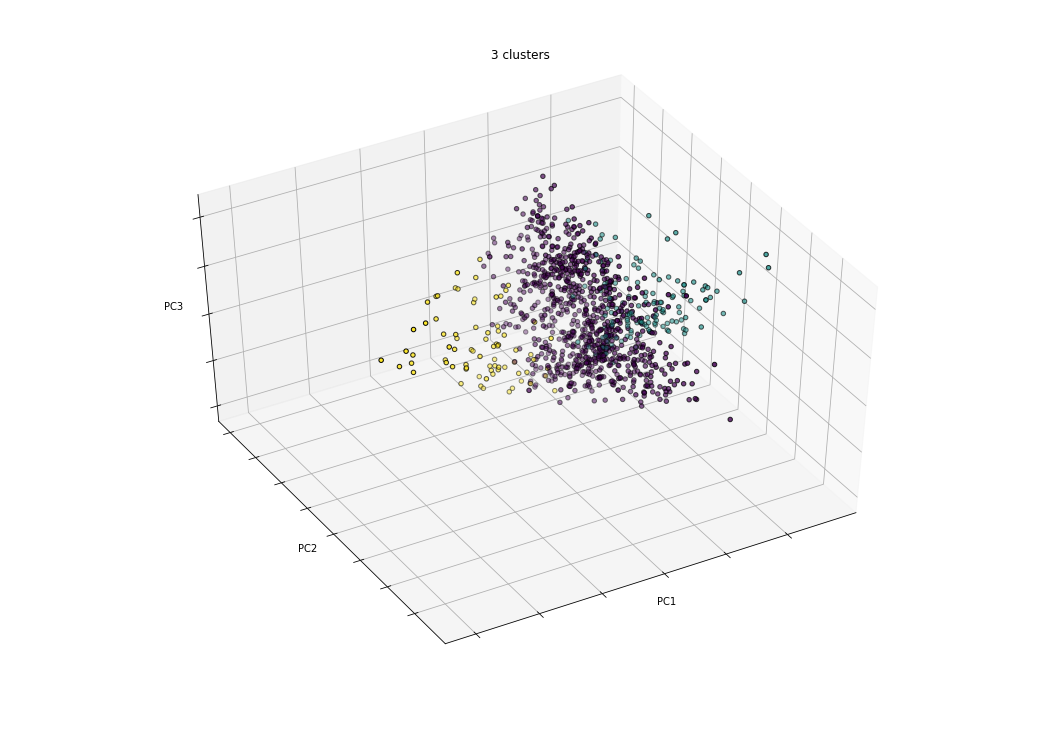

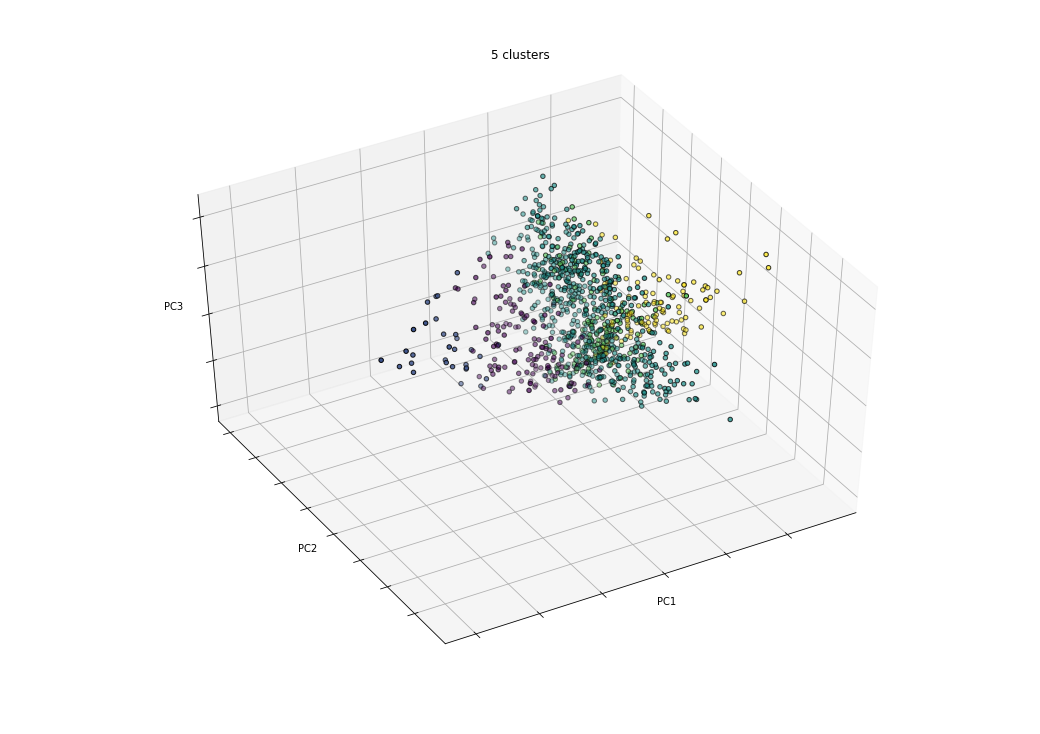

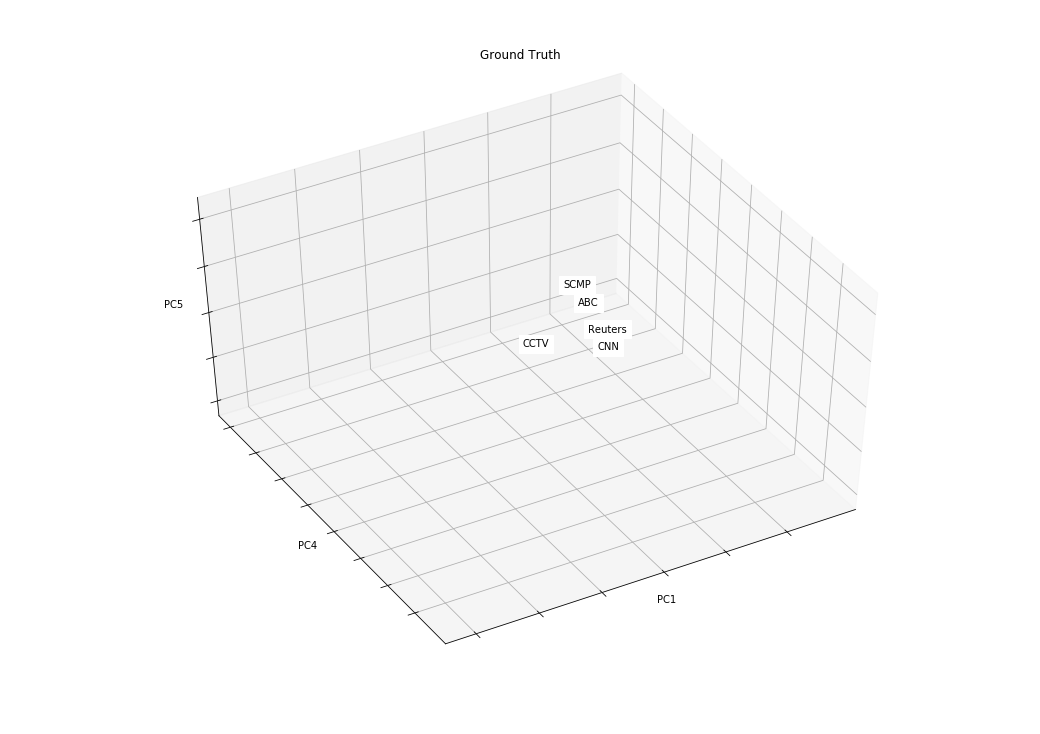

In [719]:
estimators = [('k_means_top_senti_2', KMeans(n_clusters=2)),
              ('k_means_top_senti_3', KMeans(n_clusters=3)),
              ('k_means_top_senti_5', KMeans(n_clusters=5))]

fignum = 1
titles = ['2 clusters', '3 clusters', '5 clusters']
for name, est in estimators:
    fig = plt.figure(fignum, figsize=(15, 10))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=60)
    est.fit(X_array)
    labels = est.labels_

    ax.scatter(X_array[:, 0], X_array[:, 3], X_array[:, 4],
               c=labels.astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title(titles[fignum - 1])
    ax.dist = 12
    fignum = fignum + 1

# # Plot the ground truth
fig = plt.figure(figsize=(15, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=50, azim=60)

for name, label in [('SCMP', 0),
                    ('ABC', 1),
                    ('Reuters', 2),
                    ('CCTV', 3),
                    ('CNN', 4)]:
    ax.text3D(X_array[y1 == label, 0].mean(),
              X_array[y1 == label, 3].mean(),
              X_array[y1 == label, 4].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=1, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
# y = np.choose(y, [1, 3, 4])
ax.scatter(X_array[:, 0], X_array[:, 3], X_array[:, 4], c=y1, edgecolor='k', alpha=0)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('PC1')
ax.set_ylabel('PC4')
ax.set_zlabel('PC5')
ax.set_title('Ground Truth')
ax.dist = 12

fig.show()

In [312]:
cond1 = (comp_df['source'] == 'CCTV')
cond2 = (comp_df['source'] == 'CNN')
cond3 = (comp_df['source'] == 'ABC (Australia)')
cond4 = (comp_df['source'] == 'SCMP')
cond5 = (comp_df['source'] == 'Reuters')

In [618]:
n = 4
hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
kc = KMeans(n_clusters=n)

In [619]:
y_hc = hc.fit(X1)
y_kc = kc.fit(X1)

In [620]:
comp_df['hc_labels'] = y_hc.labels_
comp_df['kc_labels'] = y_kc.labels_

In [621]:
print('Hierarchical Clustering:', sklearn.metrics.silhouette_score(X1, comp_df['hc_labels']))
print('K-Means Clustering:', sklearn.metrics.silhouette_score(X1, comp_df['kc_labels']))

Hierarchical Clustering: 0.34360049152182565
K-Means Clustering: 0.38587148392655357


In [623]:
n = 2
hc2 = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
kc2 = KMeans(n_clusters=n)

In [624]:
plot2_df = comp_df
y_hc2 = hc2.fit(X1)
y_kc2 = kc2.fit(X1)
plot2_df['hc_labels'] = y_hc2.labels_
plot2_df['kc_labels'] = y_kc2.labels_

In [625]:
print('Hierarchical Clustering:', sklearn.metrics.silhouette_score(X1, plot2_df['hc_labels']))
print('K-Means Clustering:', sklearn.metrics.silhouette_score(X1, plot2_df['kc_labels']))

Hierarchical Clustering: 0.5679372623826787
K-Means Clustering: 0.4994789911276598


In [626]:
plot_df['kc_labels'] = plot_df['kc_labels'].astype('str')
plot2_df['kc_labels'] = plot2_df['kc_labels'].astype('str')
plot_df['hc_labels'] = plot_df['hc_labels'].astype('str')
plot2_df['hc_labels'] = plot2_df['hc_labels'].astype('str')

In [622]:
color_map = {'0': 'green', '1': 'blue', '2': 'red', '3': 'darkorange'}
fig = px.scatter(plot_df, x='pc1', y='pc3',
                 color='kc_labels',
                 color_discrete_map=color_map, opacity=0.8)
fig.update_layout(legend_orientation="h")
fig.update_layout(
    shapes=[dict(type="circle",
                 xref="x",
                 yref="y",
                 x0=min(plot_df.loc[plot_df['kc_labels'] == '0' ]['pc1']),
                 y0=min(plot_df.loc[plot_df['kc_labels'] == '0' ]['pc3']),
                 x1=max(plot_df.loc[plot_df['kc_labels'] == '0' ]['pc1']),
                 y1=max(plot_df.loc[plot_df['kc_labels'] == '0' ]['pc3']),
                 opacity=0.2,
                 fillcolor="green",
                 line_color="green"),
            dict(type="circle",
                 xref="x",
                 yref="y",
                 x0=min(plot_df.loc[plot_df['kc_labels'] == '1' ]['pc1']),
                 y0=min(plot_df.loc[plot_df['kc_labels'] == '1' ]['pc3']),
                 x1=max(plot_df.loc[plot_df['kc_labels'] == '1' ]['pc1']),
                 y1=max(plot_df.loc[plot_df['kc_labels'] == '1' ]['pc3']),
                 opacity=0.2,
                 fillcolor="blue",
                 line_color="blue"),
            dict(type="circle",
                 xref="x",
                 yref="y",
                 x0=min(plot_df.loc[plot_df['kc_labels'] == '2' ]['pc1']),
                 y0=min(plot_df.loc[plot_df['kc_labels'] == '2' ]['pc3']),
                 x1=max(plot_df.loc[plot_df['kc_labels'] == '2' ]['pc1']),
                 y1=max(plot_df.loc[plot_df['kc_labels'] == '2' ]['pc3']),
                 opacity=0.2,
                 fillcolor="red",
                 line_color="red"),
            dict(type="circle",
                 xref="x",
                 yref="y",
                 x0=min(plot_df.loc[plot_df['kc_labels'] == '3' ]['pc1']),
                 y0=min(plot_df.loc[plot_df['kc_labels'] == '3' ]['pc3']),
                 x1=max(plot_df.loc[plot_df['kc_labels'] == '3' ]['pc1']),
                 y1=max(plot_df.loc[plot_df['kc_labels'] == '3' ]['pc3']),
                 opacity=0.2,
                 fillcolor="darkorange",
                 line_color="darkorange")])

fig.update_layout(
    title={'text': 'K-Means Clusters (n=4) in 2D (n-components=6)',
           'y':0.9,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    font=dict(family='Arial',
              size=18,
              color='#7f7f7f'))
fig.update_layout(xaxis_title="Principal Component 1",
                  yaxis_title="Principal Component 3",
                  font=dict(family='Arial',
                            size=12,
                            color='#7f7f7f'))

fig.show()

In [627]:
color_map = {'0': 'lightslategray', '1': 'crimson'}
fig = px.scatter(plot2_df, x='pc1', y='pc3',
                 color='hc_labels',
                 color_discrete_map=color_map, opacity=0.8)
fig.update_layout(legend_orientation="h")
fig.update_layout(
    shapes=[dict(type="circle",
                 xref="x",
                 yref="y",
                 x0=min(plot2_df.loc[plot2_df['hc_labels'] == '0' ]['pc1']),
                 y0=min(plot2_df.loc[plot2_df['hc_labels'] == '0' ]['pc3']),
                 x1=max(plot2_df.loc[plot2_df['hc_labels'] == '0' ]['pc1']),
                 y1=max(plot2_df.loc[plot2_df['hc_labels'] == '0' ]['pc3']),
                 opacity=0.2,
                 fillcolor="lightslategray",
                 line_color="lightslategray"),
            dict(type="circle",
                 xref="x",
                 yref="y",
                 x0=min(plot2_df.loc[plot2_df['hc_labels'] == '1' ]['pc1']),
                 y0=min(plot2_df.loc[plot2_df['hc_labels'] == '1' ]['pc3']),
                 x1=max(plot2_df.loc[plot2_df['hc_labels'] == '1' ]['pc1']),
                 y1=max(plot2_df.loc[plot2_df['hc_labels'] == '1' ]['pc3']),
                 opacity=0.2,
                 fillcolor="crimson",
                 line_color="crimson")])

fig.update_layout(
    title={'text': 'Hierarchical Clusters (n=2) in 2D (n-components=6)',
           'y':0.9,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    font=dict(family='Arial',
              size=18,
              color='#7f7f7f'))
fig.update_layout(xaxis_title="Principal Component 1",
                  yaxis_title="Principal Component 3",
                  font=dict(family='Arial',
                            size=12,
                            color='#7f7f7f'))

fig.show()

In [601]:
plot2_df.groupby('source')['hc_labels'].value_counts()

source           hc_labels
ABC (Australia)  0             83
                 1              1
CCTV             0             96
                 1             45
CNN              0             59
Reuters          0            351
                 1              4
SCMP             0            432
                 1              1
Name: hc_labels, dtype: int64

In [628]:
outlets = ['CCTV', 'Everyone else']
colors = ['indianred'] * 2
colors[0] = 'crimson'
fig = go.Figure([go.Bar(x=outlets,
                        y=[45, 6],
                        marker_color=colors)])
fig.update_layout(
    title={'text': 'Cluster 1 (Agglomerative Clustering, n=2)',
           'y':0.9,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    font=dict(family='Arial',
              size=18,
              color='#7f7f7f'))
fig.update_layout(xaxis_title="Sources",
                  yaxis_title="Total Counts",
                  font=dict(family='Arial',
                            size=12,
                            color='#7f7f7f'))

fig.show()

In [461]:
# color_map = {'CCTV': 'red', 'SCMP': 'darkslategrey', 'ABC (Australia)': 'khaki'}
fig = px.scatter_3d(plot_df, x='pc1', y='pc3', z='pc4', color='hc_labels', symbol='source', opacity=0.8)
fig.update_layout(showlegend=False)
fig.show()

In [409]:
tsne_comp = TSNE(n_components=2, perplexity=100, early_exaggeration=100).fit_transform(X_train)

In [410]:
tsne_array = np.concatenate((tsne_comp, np.array(y_train).reshape(1072, 2)), axis=1)

In [411]:
tsne_df = pd.DataFrame(data=tsne_array, columns=['tsne1', 'tsne2', 'source', 'date'])

In [412]:
tsne_df['hc_labels'] = y_hc.labels_
tsne_df['kc_labels'] = y_kc.labels_

In [417]:
fig = px.scatter(tsne_df, x='tsne1', y='tsne2',
                 color='kc_labels', opacity=0.8,
                 title='2-D TSNE Distribution of Articles')
fig.show()

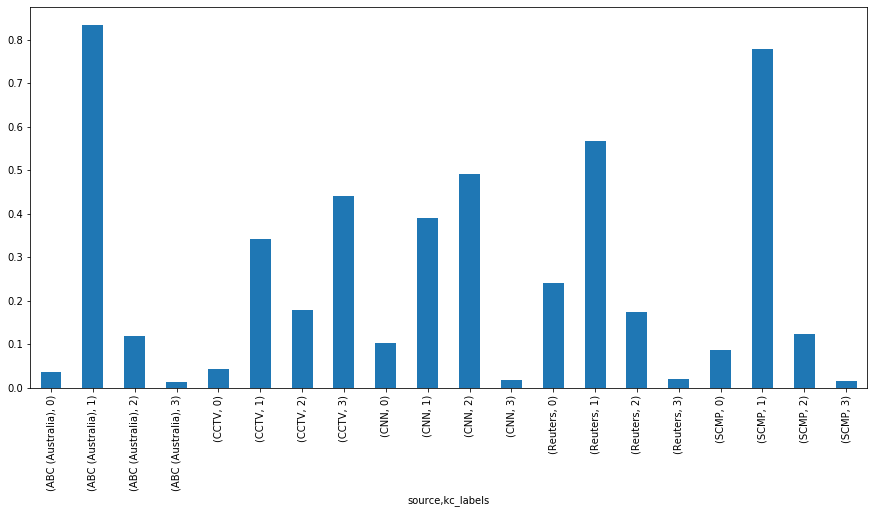

In [465]:
fig, ax = plt.subplots(figsize=(15,7))
comp_df.groupby('source')['kc_labels'].value_counts(normalize=True, sort=False).plot(ax=ax, kind='bar')
plt.show()

In [539]:
abc = np.array(round(comp_df.groupby('source')['kc_labels'].value_counts(normalize=True, sort=False)['ABC (Australia)']*100))
cctv = np.array(round(comp_df.groupby('source')['kc_labels'].value_counts(normalize=True, sort=False)['CCTV']*100))
cnn = np.array(round(comp_df.groupby('source')['kc_labels'].value_counts(normalize=True, sort=False)['CNN']*100))
reuters = np.array(round(comp_df.groupby('source')['kc_labels'].value_counts(normalize=True, sort=False)['Reuters']*100))
scmp = np.array(round(comp_df.groupby('source')['kc_labels'].value_counts(normalize=True, sort=False)['SCMP']*100))

# label_source.loc['ABC (Australia)'] = abc
# label_source.loc['CCTV'] = cctv
# label_source.loc['CNN'] = cnn
# label_source.loc['Reuters'] = reuters
# label_source.loc['SCMP'] = scmp

In [540]:
sources = ['ABC (Australia)', 'CCTV', 'CNN', 'Reuters', 'SCMP']
labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']

In [541]:
ls = np.concatenate((abc, cctv, cnn, reuters, scmp), axis=0).reshape(5,4)

In [542]:
ls

array([[ 4., 83., 12.,  1.],
       [ 4., 34., 18., 44.],
       [10., 39., 49.,  2.],
       [24., 57., 17.,  2.],
       [ 9., 78., 12.,  1.]])

In [551]:
x_data = ls
y_data = sources
top_labels = labels
colors = ['rgba(38, 24, 74, 0.8)', 'rgba(71, 58, 131, 0.8)',
          'rgba(122, 120, 168, 0.8)', 'rgba(164, 163, 204, 0.85)']

fig = go.Figure()

for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))

fig.update_layout(
    xaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=False,
        zeroline=False,
        domain=[0.15, 1]
    ),
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=False,
        zeroline=False,
    ),
    barmode='stack',
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
    margin=dict(l=10, r=40, t=140, b=80),
    showlegend=False,
)

annotations = []

for yd, xd in zip(y_data, x_data):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=10,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    # labeling the first percentage of each bar (x_axis)
    annotations.append(dict(xref='x', yref='y',
                            x=xd[0] / 2, y=yd,
                            text=str(xd[0]) + '%',
                            font=dict(family='Arial', size=10,
                                      color='rgb(248, 248, 255)'),
                            showarrow=False))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=10,
                                          color='rgb(67, 67, 67)'),
                                showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the rest of percentages for each bar (x_axis)
            annotations.append(dict(xref='x', yref='y',
                                    x=space + (xd[i]/2), y=yd,
                                    text=str(xd[i]) + '%',
                                    font=dict(family='Arial', size=10,
                                              color='rgb(248, 248, 255)'),
                                    showarrow=False))
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=10,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]

fig.update_layout(annotations=annotations)
fig.update_layout(
    title={'text': 'Cluster Groups by Source',
           'y':0.9,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
           font=dict(
               family='Arial',
               size=18,
               color='#7f7f7f'))
fig.show()

In [501]:

fig.update_layout(barmode='stack')
fig.show()